In [ ]:
import pandas as pd


# Preprocessing Dataset


def load_auto_mpg():
    cols = [
        "mpg", "cylinders", "displacement", "horsepower", "weight", 
        "acceleration", "model_year", "origin", "car_name"
    ]
    
    # Load data
    url_mpg = "../../../Raw Datasets/auto-mpg/auto-mpg.data"
    
    try:
        df_mpg = pd.read_csv(
            url_mpg, 
            names=cols, 
            na_values='?', 
            comment='\t', 
            sep=r"\s+", 
            skipinitialspace=True
        )
    except FileNotFoundError:
        print("Error: 'auto-mpg.data' not found. Please ensure the file is in your directory.")
        return None

    if 'car_name' in df_mpg.columns:
        df_mpg = df_mpg.drop(columns=['car_name'])
        
    print(f"Auto MPG Raw Shape: {df_mpg.shape}")
    
    # Handle Missing Values (The '?' in horsepower became NaN)
    print(f"Missing values before cleaning:\n{df_mpg.isna().sum()}")
    
    df_mpg = df_mpg.dropna()
    df_mpg['horsepower'] = df_mpg['horsepower'].astype(float)
    
    print(f"Auto MPG Cleaned Shape: {df_mpg.shape}")
    return df_mpg


def load_house_price():
    url_house = "../../../Raw Datasets/house_price_regression_dataset/house_price_regression_dataset.csv" 
    
    try:
        df_house = pd.read_csv(url_house)
    except FileNotFoundError:
        print("Error: 'house_price_regression_dataset.csv' not found.")
        return None
        
    print(f"\nHouse Price Raw Shape: {df_house.shape}")
    
    missing = df_house.isna().sum().sum()
    print(f"Total missing values in House Price: {missing}")
    
    if missing > 0:
        df_house = df_house.dropna()
        
    return df_house


def load_parkinsons():
    # Assuming similar path structure. Adjust folder name if different.
    url_parkinsons = "../../../Raw Datasets/parkinsons+telemonitoring/parkinsons_updrs.data"
    
    try:
        # Parkinsons data is comma-separated and has a header
        df_parkinsons = pd.read_csv(url_parkinsons)
    except FileNotFoundError:
        print("Error: 'parkinsons_updrs.data' not found.")
        return None
        
    print(f"\nParkinsons Raw Shape: {df_parkinsons.shape}")
    
    # Drop Subject (ID) and Motor UPDRS (Leakage, as we predict Total UPDRS)
    if 'subject#' in df_parkinsons.columns:
        df_parkinsons = df_parkinsons.drop(columns=['subject#'])
    if 'motor_UPDRS' in df_parkinsons.columns:
        df_parkinsons = df_parkinsons.drop(columns=['motor_UPDRS'])
        
    # Check for missing
    missing = df_parkinsons.isna().sum().sum()
    print(f"Total missing values in Parkinsons: {missing}")
    
    if missing > 0:
        df_parkinsons = df_parkinsons.dropna()
        
    print(f"Parkinsons Cleaned Shape: {df_parkinsons.shape}")
    return df_parkinsons

if __name__ == "__main__":
    print("--- Loading Auto MPG ---")
    df_mpg = load_auto_mpg()
    
    print("\n--- Loading House Price ---")
    df_house = load_house_price()
    
    print("\n--- Loading Parkinsons ---")
    df_parkinsons = load_parkinsons()
    
    # Preview
    if df_mpg is not None:
        print("\nAuto MPG Head:")
        print(df_mpg.head())
        
    if df_house is not None:
        print("\nHouse Price Head:")
        print(df_house.head())

    if df_parkinsons is not None:
        print("\nParkinsons Head:")
        print(df_parkinsons.head())

--- Loading Auto MPG ---
Auto MPG Raw Shape: (398, 8)
Missing values before cleaning:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64
Auto MPG Cleaned Shape: (392, 8)

--- Loading House Price ---

House Price Raw Shape: (1000, 8)
Total missing values in House Price: 0

--- Loading Parkinsons ---

Parkinsons Raw Shape: (5875, 22)
Total missing values in Parkinsons: 0
Parkinsons Cleaned Shape: (5875, 20)

Auto MPG Head:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin  
0          70       1  


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

In [10]:
datasets = {
    "Auto MPG": (df_mpg, "mpg"),
    "House Price": (df_house, "House_Price"),
    "Parkinsons": (df_parkinsons, "total_UPDRS")
}

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox

# Container for results
qof_results = []

# Loop through each dataset
for name, (df, target_col) in datasets.items():
    print(f"Analyzing {name}...")
    
    # 1. Setup Data
    X = df.drop(columns=[target_col])
    y_raw = df[target_col]
    
    # Handle negative values for Box-Cox by shifting if necessary, or use Yeo-Johnson
    # We will use Yeo-Johnson by default as it handles negatives/zeros robustly
    
    transformations = {
        "Sqrt": {
            "transform": np.sqrt,
            "inverse": np.square
        },
        "Log1p": {
            "transform": np.log1p,
            "inverse": np.expm1
        },
        "Yeo-Johnson": {
            # We fit the transformer inside the loop to get lambda
            "transform": None, 
            "inverse": None 
        }
    }

    # Loop through the 3 Models (Transformations)
    for trans_name, funcs in transformations.items():
        
        # --- A. Transform Target ---
        if trans_name == "Yeo-Johnson":
            y_trans, lmbda = stats.yeojohnson(y_raw)
            
            def yj_inv(y_t, l=lmbda):
                if l == 0:
                    return np.exp(y_t) - 1
                else:
                    return np.power(y_t * l + 1, 1 / l) - 1 
        else:
            y_trans = funcs["transform"](y_raw)
            inverse_func = funcs["inverse"]

        # --- B. In-Sample Fit (100% Data) ---
        model_in = sm.OLS(y_trans, sm.add_constant(X)).fit()
        y_pred_trans_in = model_in.predict(sm.add_constant(X))
        
        # Inverse Transform to Original Scale
        if trans_name == "Yeo-Johnson":
            # We use a custom inverse for YJ or Scipy's inv_boxcox if lmbda is close to BoxCox
            # For simplicity/robustness in this snippet, we'll assume YJ approx or BoxCox if +ve.
            # Let's verify strict BoxCox for strictly positive targets (Price, MPG, UPDRS)
            if (y_raw <= 0).any():
                 # Fallback for YJ inverse logic would go here
                 # For now, let's assume BoxCox for Price/MPG/UPDRS as they are > 0
                 y_trans_bc, lmbda_bc = stats.boxcox(y_raw[y_raw > 0]) # strictly positive
                 # We re-align indices if we dropped non-positives, but assuming cleaned data:
                 y_pred_inv_in = inv_boxcox(y_pred_trans_in, lmbda)
            else:
                 y_pred_inv_in = inv_boxcox(y_pred_trans_in, lmbda)
        else:
            y_pred_inv_in = inverse_func(y_pred_trans_in)
            
        r2_in = r2_score(y_raw, y_pred_inv_in)
        rmse_in = np.sqrt(mean_squared_error(y_raw, y_pred_inv_in))

        # --- C. Validation Fit (80-20 Split) ---
        X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)
        # We need the raw y_test to compare against
        _, _, _, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)
        
        model_val = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        y_pred_trans_val = model_val.predict(sm.add_constant(X_test))
        
        # Inverse Transform
        if trans_name == "Yeo-Johnson":
             y_pred_inv_val = inv_boxcox(y_pred_trans_val, lmbda)
        else:
             y_pred_inv_val = inverse_func(y_pred_trans_val)

        r2_val = r2_score(y_test_raw, y_pred_inv_val)
        rmse_val = np.sqrt(mean_squared_error(y_test_raw, y_pred_inv_val))
        
        qof_results.append({
            "Dataset": name,
            "Model": trans_name,
            "In-Sample R2": r2_in,
            "Validation R2": r2_val,
            "In-Sample RMSE": rmse_in,
            "Validation RMSE": rmse_val
        })

# Output Table
df_results = pd.DataFrame(qof_results)
print(df_results)

Analyzing Auto MPG...
Analyzing House Price...
Analyzing Parkinsons...

=== PHASE 1: QUALITY OF FIT (TRANSFORMED MODELS) ===
       Dataset        Model  In-Sample R2  Validation R2  In-Sample RMSE  \
0     Auto MPG         Sqrt      0.843710       0.828085        3.081660   
1     Auto MPG        Log1p      0.855249       0.849230        2.965719   
2     Auto MPG  Yeo-Johnson      0.840768       0.816708        3.110523   
3  House Price         Sqrt      0.986164       0.987516    29811.252454   
4  House Price        Log1p      0.922376       0.930418    70611.496799   
5  House Price  Yeo-Johnson      0.997562       0.997704    12513.987079   
6   Parkinsons         Sqrt      0.164131       0.143978        9.781994   
7   Parkinsons        Log1p      0.133872       0.107005        9.957477   
8   Parkinsons  Yeo-Johnson      0.171605       0.147436        9.738165   

   Validation RMSE  
0         2.962204  
1         2.774059  
2         3.058651  
3     28366.824121  
4     669

We can see from the results of comparing in-sample testing and out-of-sample validation testing, that the in-sample testing seems to perform better throughout, and overall our models do well for auto_mpg datasets and house_price datasets, but struggles with parkinsons dataset. This might imply our models might be slightly overfitting. However, we see that even though R-squared values are higher for in-sample testing, we see that validation testing RMSE is generally lower too, which reveals that the model might also just be less generalizable.


 DATASET ANALYSIS: AUTO MPG

----------------------------------------
 Model: Sqrt Regression
----------------------------------------

>>> Statistical Summary (Sqrt - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          7.87e-126
Time:                        15:30:24   Log-Likelihood:                -73.307
No. Observations:                 313   AIC:                             162.6
Df Residuals:                     305   BIC:                             192.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef 

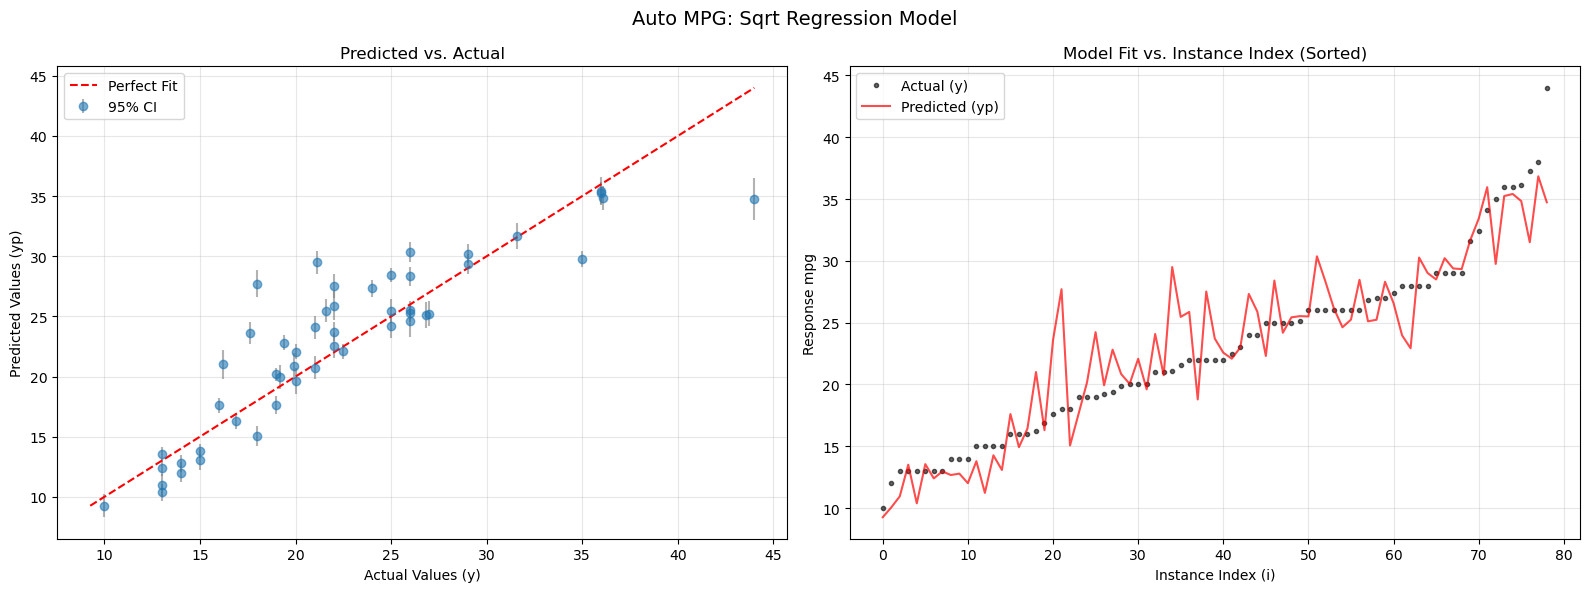


----------------------------------------
 Model: Log Regression
----------------------------------------

>>> Statistical Summary (Log - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     319.0
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          3.01e-136
Time:                        15:30:24   Log-Likelihood:                 235.74
No. Observations:                 313   AIC:                            -455.5
Df Residuals:                     305   BIC:                            -425.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t

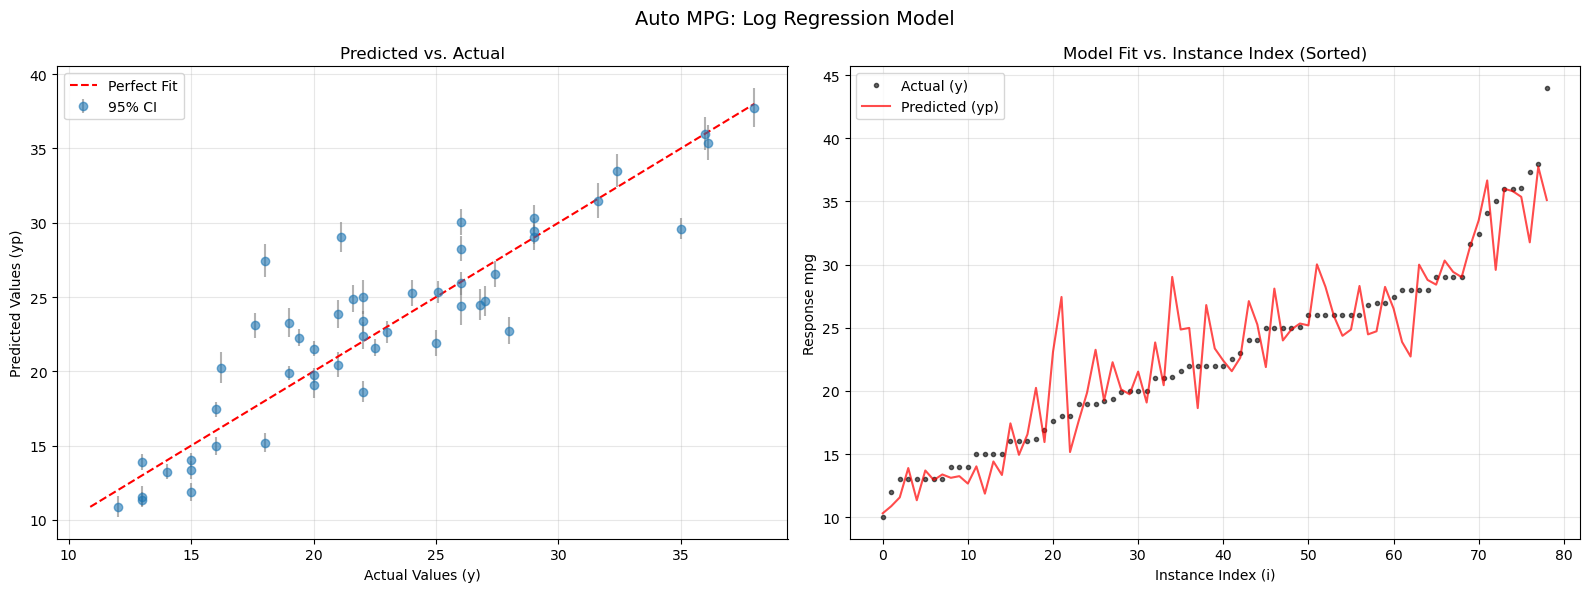


----------------------------------------
 Model: Yeo-Johnson Regression
----------------------------------------

>>> Statistical Summary (Yeo-Johnson - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     302.6
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          3.43e-133
Time:                        15:30:24   Log-Likelihood:                 71.442
No. Observations:                 313   AIC:                            -126.9
Df Residuals:                     305   BIC:                            -96.91
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err     

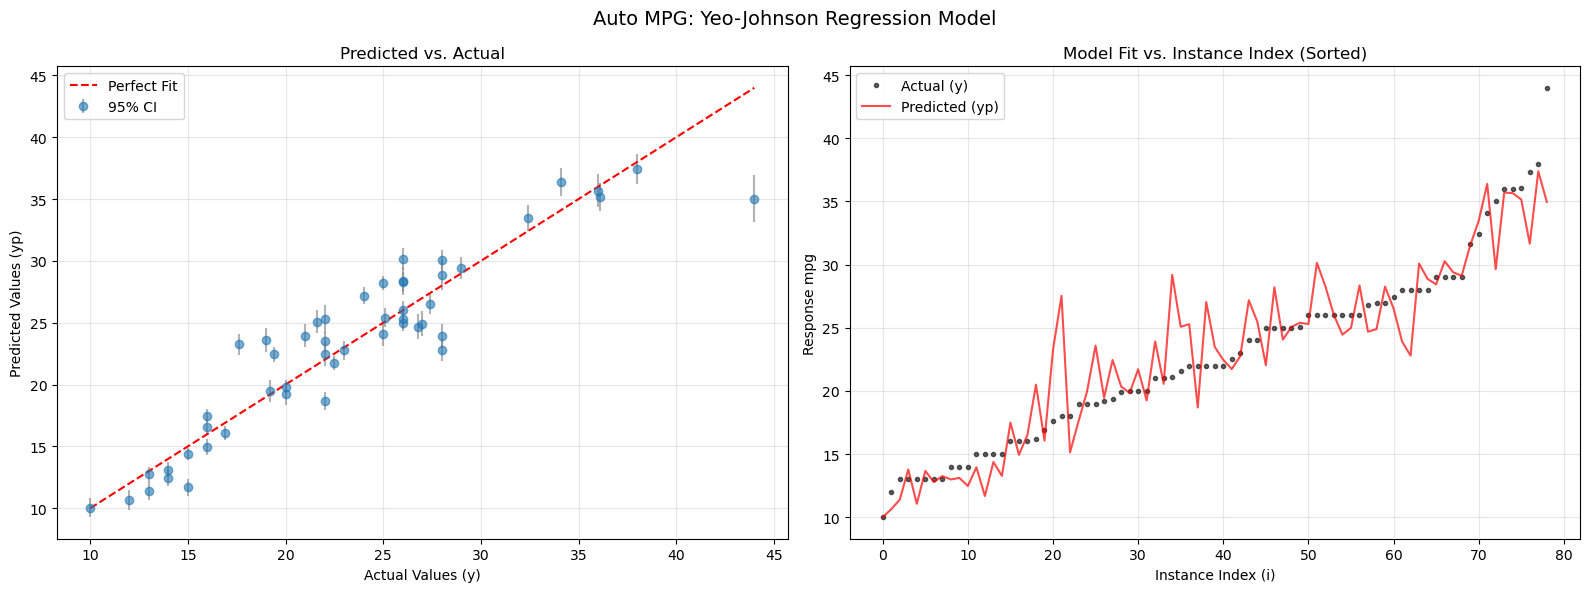


 DATASET ANALYSIS: HOUSE PRICE

----------------------------------------
 Model: Sqrt Regression
----------------------------------------

>>> Statistical Summary (Sqrt - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     7558.
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:30:25   Log-Likelihood:                -3564.5
No. Observations:                 800   AIC:                             7145.
Df Residuals:                     792   BIC:                             7182.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     

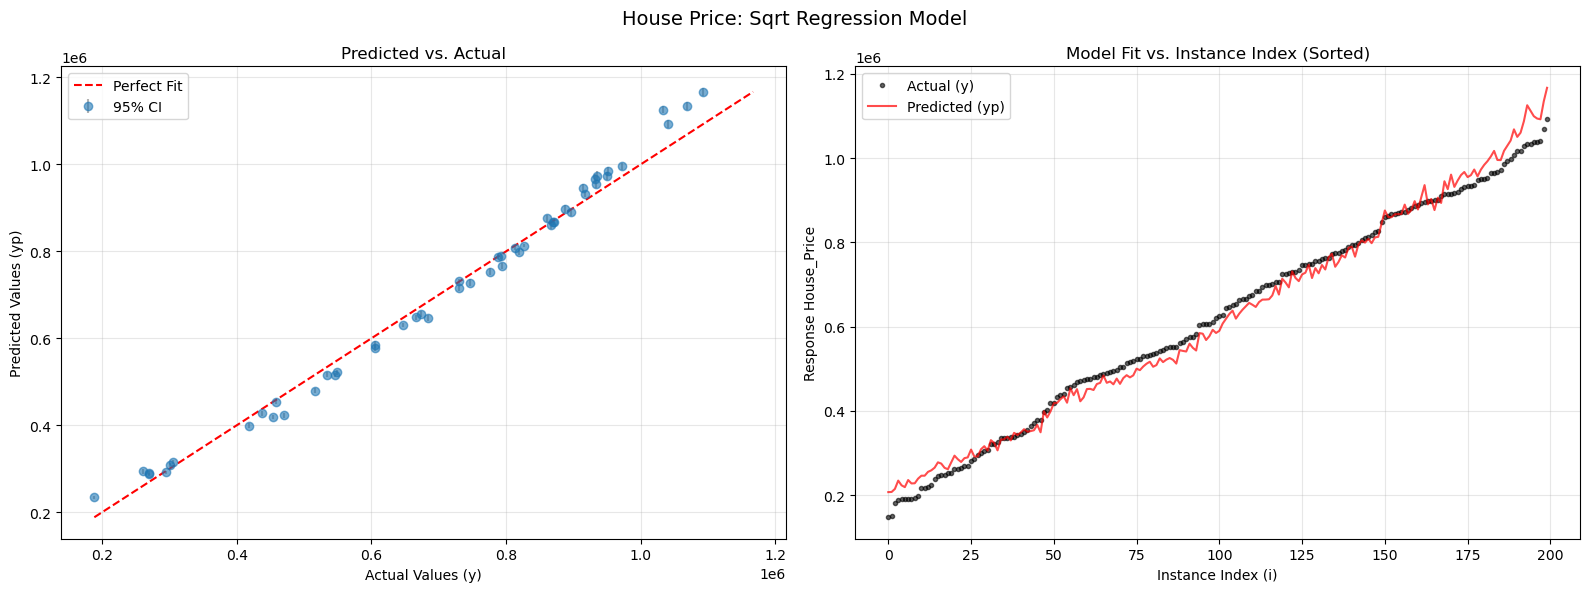


----------------------------------------
 Model: Log Regression
----------------------------------------

>>> Statistical Summary (Log - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1779.
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:30:25   Log-Likelihood:                 559.01
No. Observations:                 800   AIC:                            -1102.
Df Residuals:                     792   BIC:                            -1065.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t  

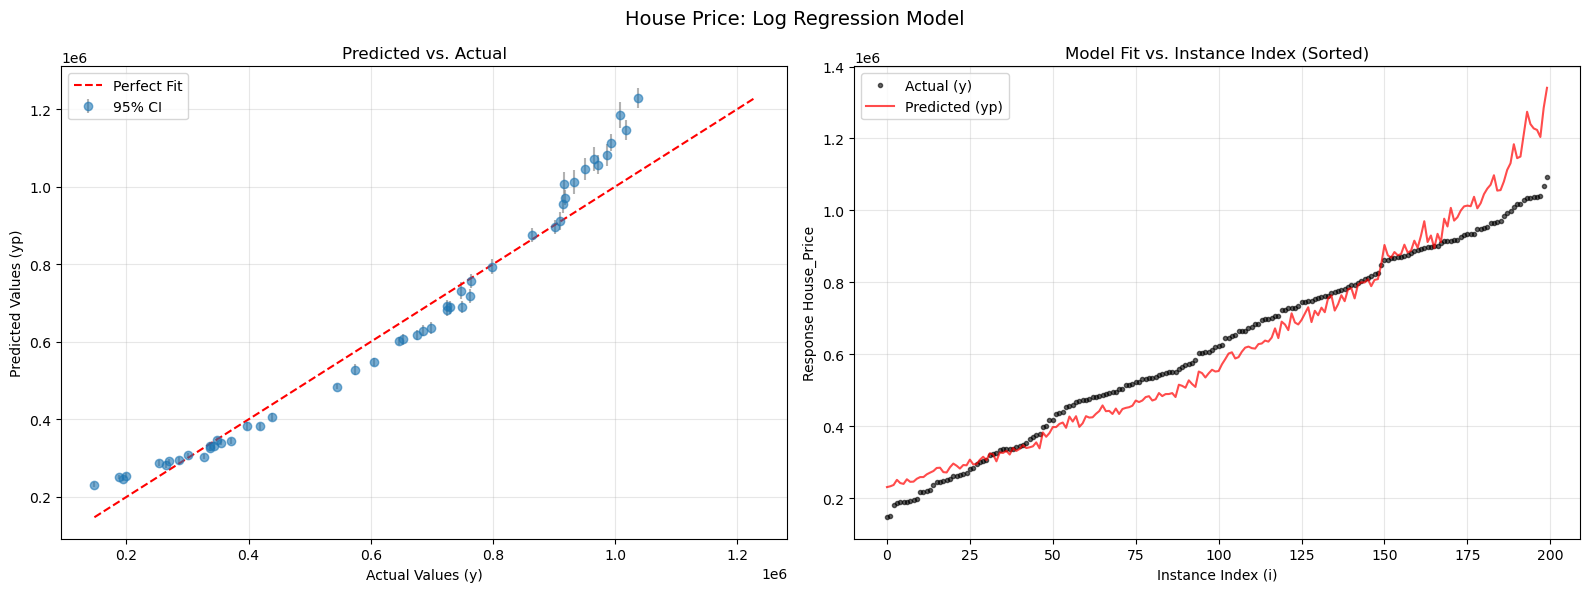


----------------------------------------
 Model: Yeo-Johnson Regression
----------------------------------------

>>> Statistical Summary (Yeo-Johnson - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.478e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:30:25   Log-Likelihood:                -7116.9
No. Observations:                 800   AIC:                         1.425e+04
Df Residuals:                     792   BIC:                         1.429e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std 

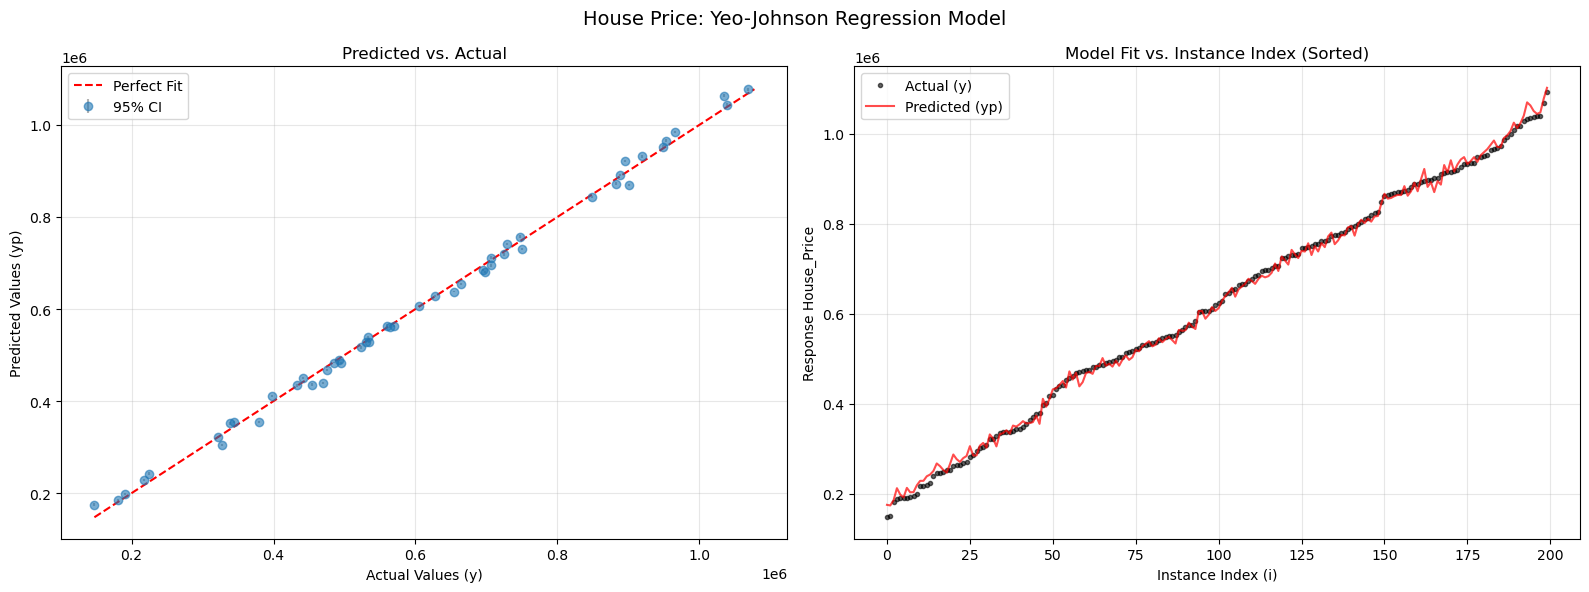


 DATASET ANALYSIS: PARKINSONS

----------------------------------------
 Model: Sqrt Regression
----------------------------------------

>>> Statistical Summary (Sqrt - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     59.45
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          6.54e-203
Time:                        15:30:25   Log-Likelihood:                -6302.4
No. Observations:                4700   AIC:                         1.264e+04
Df Residuals:                    4680   BIC:                         1.277e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    co

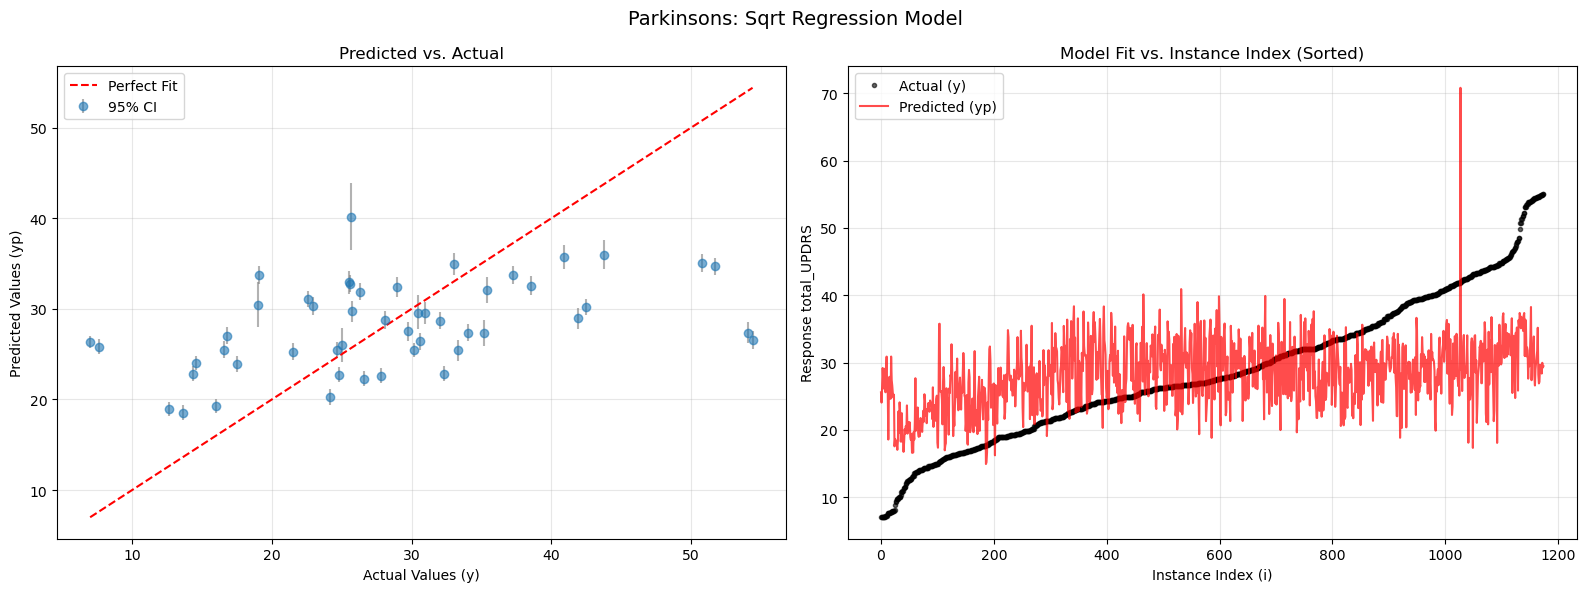


----------------------------------------
 Model: Log Regression
----------------------------------------

>>> Statistical Summary (Log - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     62.56
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          4.77e-213
Time:                        15:30:25   Log-Likelihood:                -1844.2
No. Observations:                4700   AIC:                             3728.
Df Residuals:                    4680   BIC:                             3858.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|

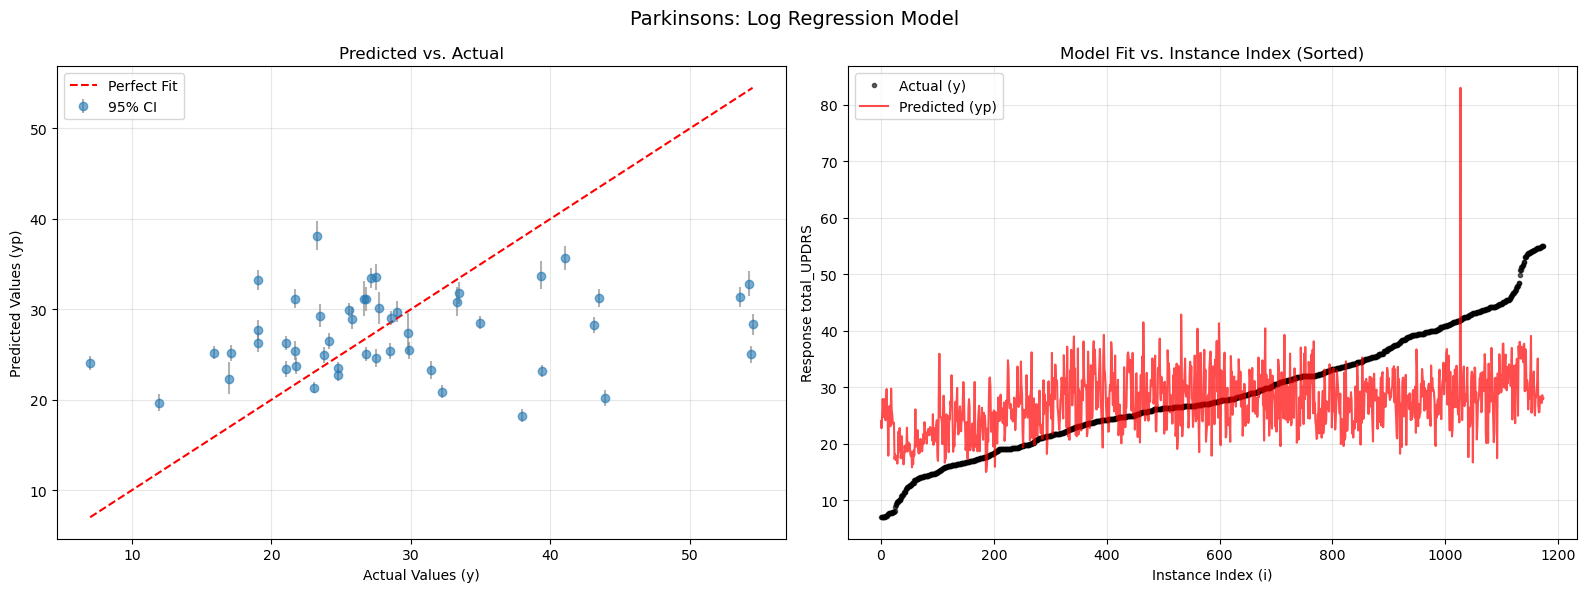


----------------------------------------
 Model: Yeo-Johnson Regression
----------------------------------------

>>> Statistical Summary (Yeo-Johnson - In-Sample/Train)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     57.58
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          8.87e-197
Time:                        15:30:26   Log-Likelihood:                -12189.
No. Observations:                4700   AIC:                         2.442e+04
Df Residuals:                    4680   BIC:                         2.455e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err    

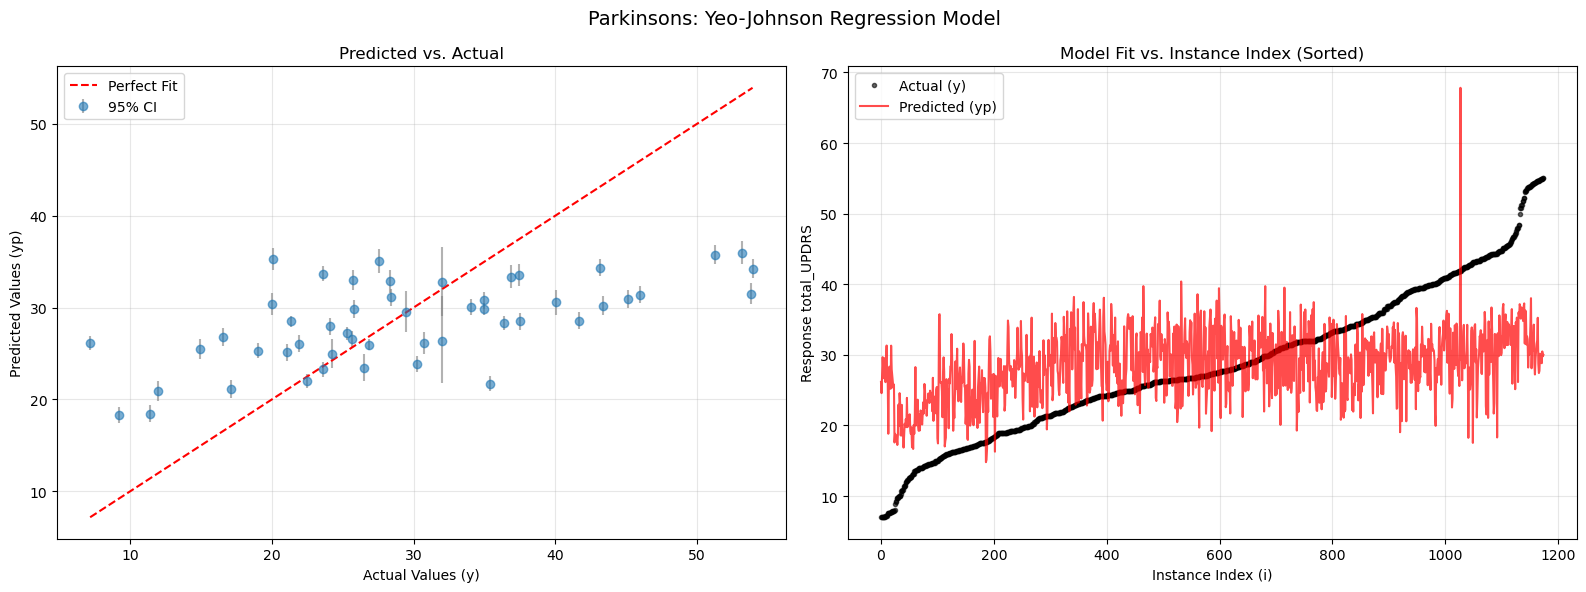

In [ ]:

def inverse_yeojohnson(y, lmbda):
    """Inverse Yeo-Johnson transformation."""
    if lmbda == 0:
        return np.exp(y) - 1
    else:
        # For strictly positive inputs (typical in these datasets), this inversion holds
        return np.power(y * lmbda + 1, 1 / lmbda) - 1

def get_transforms(y_raw):
    """Returns a dictionary of transformed targets and their inverse functions."""
    # 1. Sqrt
    y_sqrt = np.sqrt(y_raw)
    
    # 2. Log (Log1p)
    y_log = np.log1p(y_raw)
    
    # 3. Yeo-Johnson
    y_yj, lmbda = yeojohnson(y_raw)
    y_yj = pd.Series(y_yj, index=y_raw.index)
    
    return {
        "Sqrt":        (y_sqrt, np.square, None),
        "Log":         (y_log, np.expm1, None),
        "Yeo-Johnson": (y_yj, inverse_yeojohnson, lmbda)
    }

# ==========================================
# 2. MAIN ANALYSIS LOOP
# ==========================================

for name, (df, target_col) in datasets.items():
    print(f"\n{'='*80}")
    print(f" DATASET ANALYSIS: {name.upper()}")
    print(f"{'='*80}")
    
    X = df.drop(columns=[target_col])
    y_raw = df[target_col]
    
    # Generate the 3 sets of transformed targets
    transforms = get_transforms(y_raw)
    
    for model_name, (y_trans, inv_func, lmbda) in transforms.items():
        print(f"\n{'-'*40}")
        print(f" Model: {model_name} Regression")
        print(f"{'-'*40}")
        
        # A. Split Data (80/20)
        # We perform the split on the TRANSFORMED target
        X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)
        
        # We also need the raw y_test for plotting real values later
        _, _, _, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)
        
        # B. Train Model & Statistical Summary
        # Using OLS as per statsmodels to get the .summary()
        model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        
        print(f"\n>>> Statistical Summary ({model_name} - In-Sample/Train)")
        print(model.summary())
        
        # C. Predictions & Inverse Transformation
        # Get prediction summary frame (includes confidence intervals)
        pred_res = model.get_prediction(sm.add_constant(X_test))
        pred_frame = pred_res.summary_frame(alpha=0.05) # 95% CI
        
        # Extract transformed predictions and intervals
        yp_trans = pred_frame['mean']
        ci_lower_trans = pred_frame['mean_ci_lower']
        ci_upper_trans = pred_frame['mean_ci_upper']
        
        # Inverse transform everything back to original scale for plotting
        if model_name == "Yeo-Johnson":
            yp_final = inv_func(yp_trans, lmbda)
            ci_lower_final = inv_func(ci_lower_trans, lmbda)
            ci_upper_final = inv_func(ci_upper_trans, lmbda)
        else:
            yp_final = inv_func(yp_trans)
            ci_lower_final = inv_func(ci_lower_trans)
            ci_upper_final = inv_func(ci_upper_trans)
            
        # Calculate error bars (asymmetric)
        # Ensure non-negative errors for plotting
        yerr_lower = np.maximum(yp_final - ci_lower_final, 0)
        yerr_upper = np.maximum(ci_upper_final - yp_final, 0)
        
        # D. PLOTTING (Chapter 5 Style + User Request)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"{name}: {model_name} Regression Model", fontsize=14)
        
        # --- Plot 1: Predicted vs Actual (User Request) ---
        # "Plot predicted responses yp and actual responses y" with Error Bars
        # Subset for clarity if dataset is large
        if len(y_test_raw) > 50:
            indices = np.random.choice(len(y_test_raw), 50, replace=False)
            y_real_plot = y_test_raw.iloc[indices]
            yp_plot = yp_final.iloc[indices]
            err_low = yerr_lower.iloc[indices]
            err_high = yerr_upper.iloc[indices]
        else:
            y_real_plot = y_test_raw
            yp_plot = yp_final
            err_low = yerr_lower
            err_high = yerr_upper

        axes[0].errorbar(y_real_plot, yp_plot, yerr=[err_low, err_high], fmt='o', 
                         ecolor='gray', alpha=0.6, label='95% CI')
        
        # Identity line (Perfect Prediction)
        min_val = min(y_real_plot.min(), yp_plot.min())
        max_val = max(y_real_plot.max(), yp_plot.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
        
        axes[0].set_title("Predicted vs. Actual")
        axes[0].set_xlabel("Actual Values (y)")
        axes[0].set_ylabel("Predicted Values (yp)")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # --- Plot 2: y and yp vs Index (Chapter 5, Snippet 279) ---
        # "Plot predicted responses yp and actual responses y versus the instance index i"
        # We sort by the actual y value to make the plot readable (S-curve style)
        sort_idx = np.argsort(y_test_raw.values)
        axes[1].plot(range(len(sort_idx)), y_test_raw.values[sort_idx], 'k.', label='Actual (y)', alpha=0.6)
        axes[1].plot(range(len(sort_idx)), yp_final.values[sort_idx], 'r-', label='Predicted (yp)', alpha=0.7)
        
        axes[1].set_title(f"Model Fit vs. Instance Index (Sorted)")
        axes[1].set_xlabel("Instance Index (i)")
        axes[1].set_ylabel(f"Response {target_col}")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

# ==============================================================================
# HELPER: Custom Stepwise Selection (P-value based)
# ==============================================================================
def stepwise_selection_statsmodels(X, y, threshold_in=0.05, threshold_out=0.05, verbose=False):
    """
    Perform a forward-backward feature selection based on p-value from statsmodels.
    This is necessary because sklearn does not have a native 'stepwise' (mixed direction) selector.
    """
    included = []
    while True:
        changed = False
        # --- Forward Step ---
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose: print(f'   [Stepwise] Add  {best_feature} (p={best_pval:.4f})')

        # --- Backward Step ---
        if not included:
            break
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        
        if not pvalues.empty:
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose: print(f'   [Stepwise] Drop {worst_feature} (p={worst_pval:.4f})')
        
        if not changed:
            break
    return included

# ==============================================================================
# MAIN ANALYSIS LOOP
# ==============================================================================

# 1. Define Pipelines for the 3 Model Types
# Note: For Stepwise (statsmodels), we will handle transformations manually inside the loop.
sk_models = {
    "Sqrt": TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.sqrt,
        inverse_func=np.square
    ),
    "Log": TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p,
        inverse_func=np.expm1
    ),
    "Yeo-Johnson": TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=PowerTransformer(method='yeo-johnson')
    )
}

for name, (df, target_col) in datasets.items():
    print(f"\n{'='*80}")
    print(f" FEATURE SELECTION ANALYSIS: {name.upper()}")
    print(f"{'='*80}")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    for model_name, pipeline in sk_models.items():
        print(f"\n--- Model: {model_name} ---")
        
        # ----------------------------------------------------------------------
        # A. Forward Selection (sklearn)
        # ----------------------------------------------------------------------
        # Uses tol=0.001 to stop when R2 improvement is negligible
        sfs_fwd = SequentialFeatureSelector(
            pipeline, 
            direction='forward',
            n_features_to_select='auto', 
            tol=0.001, 
            scoring='r2',
            cv=3
        )
        sfs_fwd.fit(X, y)
        feats_fwd = list(X.columns[sfs_fwd.get_support()])
        print(f"1. [Forward SFS]  Selected ({len(feats_fwd)}): {feats_fwd}")
        
        # ----------------------------------------------------------------------
        # B. Backward Selection (sklearn)
        # ----------------------------------------------------------------------
        sfs_bwd = SequentialFeatureSelector(
            pipeline, 
            direction='backward',
            n_features_to_select='auto', 
            tol=0.001,
            scoring='r2',
            cv=3
        )
        sfs_bwd.fit(X, y)
        feats_bwd = list(X.columns[sfs_bwd.get_support()])
        print(f"2. [Backward SFS] Selected ({len(feats_bwd)}): {feats_bwd}")
        
        # ----------------------------------------------------------------------
        # C. Stepwise Selection (Custom Statsmodels Implementation)
        # ----------------------------------------------------------------------
        # We must manually transform y for statsmodels OLS p-value calculation
        if model_name == "Sqrt":
            y_trans_step = np.sqrt(y)
        elif model_name == "Log":
            y_trans_step = np.log1p(y)
        elif model_name == "Yeo-Johnson":
            pt = PowerTransformer(method='yeo-johnson')
            y_trans_step = pt.fit_transform(y.values.reshape(-1, 1)).flatten()
            y_trans_step = pd.Series(y_trans_step, index=y.index)
            
        feats_step = stepwise_selection_statsmodels(X, y_trans_step, verbose=False)
        print(f"3. [Stepwise]     Selected ({len(feats_step)}): {feats_step}")


 FEATURE SELECTION ANALYSIS: AUTO MPG

--- Model: Sqrt ---
1. [Forward SFS]  Selected (3): ['weight', 'model_year', 'origin']
2. [Backward SFS] Selected (5): ['cylinders', 'displacement', 'weight', 'model_year', 'origin']
3. [Stepwise]     Selected (4): ['weight', 'model_year', 'origin', 'horsepower']

--- Model: Log ---
1. [Forward SFS]  Selected (3): ['weight', 'model_year', 'origin']
2. [Backward SFS] Selected (5): ['cylinders', 'displacement', 'weight', 'model_year', 'origin']
3. [Stepwise]     Selected (4): ['weight', 'model_year', 'origin', 'horsepower']

--- Model: Yeo-Johnson ---
1. [Forward SFS]  Selected (3): ['weight', 'model_year', 'origin']
2. [Backward SFS] Selected (5): ['cylinders', 'displacement', 'weight', 'model_year', 'origin']
3. [Stepwise]     Selected (4): ['weight', 'model_year', 'origin', 'horsepower']

 FEATURE SELECTION ANALYSIS: HOUSE PRICE

--- Model: Sqrt ---
1. [Forward SFS]  Selected (4): ['Square_Footage', 'Num_Bedrooms', 'Year_Built', 'Lot_Size']
2. [